# Acoustic Feature Analysis for Speech Signals

## Import libraries

In [1]:
# Imports for plotting and data manipulatin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Imports for audio processing
import librosa
from IPython.display import Audio
import audb
import audiofile
import opensmile
import os

# Imports for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Load the data

In [2]:
# Load emodb database
db = audb.load(
    'emodb',
    version='1.4.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    media=r'wav/14.*A.*\.wav',
    full_path=False,
    verbose=False,
)

# Read speech file
file = os.path.join(db.root, db.files[1])
signal, sampling_rate = audiofile.read(
    file,
    duration=10,
    always_2d=True,
)

# Play audio
Audio(data=signal, rate=sampling_rate)

## Extract acoustic features

In [8]:
# Loading the complete Emo-DB dataset
emodb = audb.load('emodb')

# Write your code here
# Extract emotion labels properly
emotion_table = emodb['emotion']
emotion_labels = emotion_table.df["emotion"]

# Define openSMILE extractor
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors
)

selected_features = [
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "Loudness_sma3",
    "mfcc1_sma3",
    "mfcc2_sma3",
    "mfcc3_sma3",
    "mfcc4_sma3"
]

all_features = []

# IMPORTANT: iterate over emotion_labels.index
for file in tqdm(emotion_labels.index):
    
    features = smile.process_file(file)
    features = features[selected_features]
    features = features.dropna()
    
    file_features = features.mean()
    file_dict = file_features.to_dict()
    
    file_dict["file"] = file
    file_dict["emotion"] = emotion_labels.loc[file]
    
    all_features.append(file_dict)

df_emodb = pd.DataFrame(all_features)

print(df_emodb.head())
print("Shape:", df_emodb.shape)

Get:   emodb v2.0.0
Cache: C:\Users\siris\audb\emodb\2.0.0\d3b62a9b


100%|████████████████████████████████████████████████████████████████████████████████| 816/816 [02:09<00:00,  6.32it/s]

   F0semitoneFrom27.5Hz_sma3nz  jitterLocal_sma3nz  Loudness_sma3  mfcc1_sma3  \
0                    16.858467            0.017686       0.707279   14.935056   
1                    10.678578            0.006020       0.841323   23.487043   
2                    17.989414            0.011324       1.181556   10.503195   
3                    24.539801            0.012750       0.901067   11.218029   
4                    14.231475            0.008418       0.918349   22.829060   

   mfcc2_sma3  mfcc3_sma3  mfcc4_sma3  \
0    6.007410   12.601397    0.542903   
1    2.218123   14.400658    1.159570   
2   -6.946439    9.284829   -4.284396   
3    4.177176    5.993571   -2.399915   
4    7.924610   20.471859    3.490059   

                                                file    emotion  
0  C:\Users\siris\audb\emodb\2.0.0\d3b62a9b\wav\0...  happiness  
1  C:\Users\siris\audb\emodb\2.0.0\d3b62a9b\wav\0...    neutral  
2  C:\Users\siris\audb\emodb\2.0.0\d3b62a9b\wav\0...      anger  
3 

In [9]:
# Get the emotion labels for the speech files
path = os.path.normpath(emodb.root)

emotion_file = os.path.join(path, 'db.emotion.csv')
files_file = os.path.join(path, 'db.files.csv')
speaker_file = os.path.join(path, 'db.speaker.csv')

# Load the CSV files
emotion_df = pd.read_csv(emotion_file)
files_df = pd.read_csv(files_file)
speaker_df = pd.read_csv(speaker_file)

# Merge the DataFrames
merged_df = pd.merge(emotion_df, files_df, on='file')
merged_df = pd.merge(merged_df, speaker_df, on='speaker')

merged_df.head()

,file,emotion,emotion.confidence,emotion.naturalness,duration,transcription,speaker,age,gender,language
0,wav/03a01Fa.wav,happiness,0.90,0.75,0 days 00:00:01.898250,a01,3,31,male,deu
1,wav/03a01Nc.wav,neutral,1.00,0.95,0 days 00:00:01.611250,a01,3,31,male,deu
2,wav/03a01Wa.wav,anger,0.95,0.90,0 days 00:00:01.877812500,a01,3,31,male,deu
3,wav/03a02Fc.wav,happiness,0.85,0.60,0 days 00:00:02.006250,a02,3,31,male,deu
4,wav/03a02Nc.wav,neutral,1.00,0.95,0 days 00:00:01.439812500,a02,3,31,male,deu


In [10]:
# Combine the emotion labels and acoustic features for each speech file
df_emodb["file"] = df_emodb["file"].apply(
    lambda x: os.path.join(
        os.path.basename(os.path.dirname(x)),
        os.path.basename(x)
    ).replace("\\", "/")   # ensure forward slashes
)
df_emodb = df_emodb.drop(columns=["emotion"])

# Merge the dataframes
final_df = pd.merge(
    df_emodb,
    merged_df[["file", "emotion"]],   # keep only necessary columns
    on="file"
)

# Check
print(final_df.head())
print("Shape:", final_df.shape)

   F0semitoneFrom27.5Hz_sma3nz  jitterLocal_sma3nz  Loudness_sma3  mfcc1_sma3  \
0                    16.858467            0.017686       0.707279   14.935056   
1                    10.678578            0.006020       0.841323   23.487043   
2                    17.989414            0.011324       1.181556   10.503195   
3                    24.539801            0.012750       0.901067   11.218029   
4                    14.231475            0.008418       0.918349   22.829060   

   mfcc2_sma3  mfcc3_sma3  mfcc4_sma3             file    emotion  
0    6.007410   12.601397    0.542903  wav/03a01Fa.wav  happiness  
1    2.218123   14.400658    1.159570  wav/03a01Nc.wav    neutral  
2   -6.946439    9.284829   -4.284396  wav/03a01Wa.wav      anger  
3    4.177176    5.993571   -2.399915  wav/03a02Fc.wav  happiness  
4    7.924610   20.471859    3.490059  wav/03a02Nc.wav    neutral  
Shape: (816, 9)


## K-means Clustering

### Clustering emotions

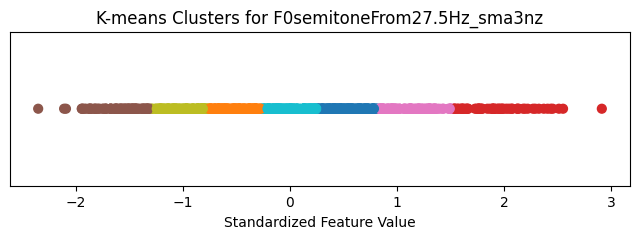

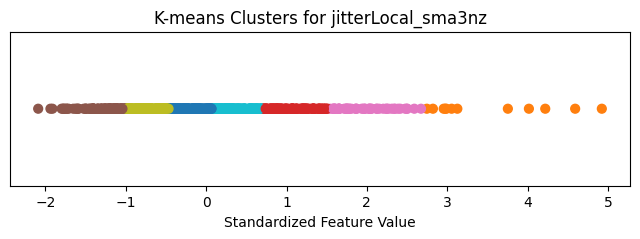

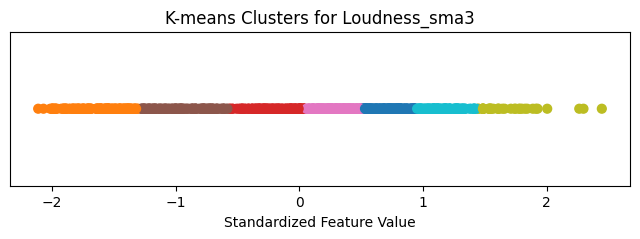

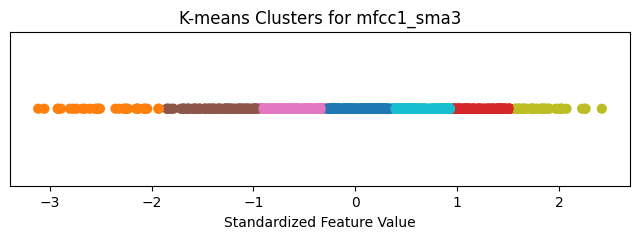

In [11]:
# Cluster the acoustic features
# Define features to cluster individually
features_to_cluster = [
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "Loudness_sma3",
    "mfcc1_sma3"
]

for feature in features_to_cluster:
    
    # Extract feature values
    X = final_df[[feature]].values
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply KMeans with 7 clusters
    kmeans = KMeans(n_clusters=7, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Plot
    plt.figure(figsize=(8, 2))
    plt.scatter(X_scaled, np.zeros_like(X_scaled),
                c=clusters, cmap='tab10', s=40)
    
    plt.title(f"K-means Clusters for {feature}")
    plt.xlabel("Standardized Feature Value")
    plt.yticks([])
    plt.show()

There are 7 clusters clearly formed along the standardized feature axis, showing structured variation in the data. However, overlap between neighboring clusters indicates that a single acoustic feature is not sufficient for clean class separation. 

To understand how well each acoustic feature captures a specific emotion, we can create a heatmap. A heatmap shows how many times each emotion appears in each cluster. The more often an emotion appears in a cluster, the better the acoustic feature is in capturing important information about that emotion.

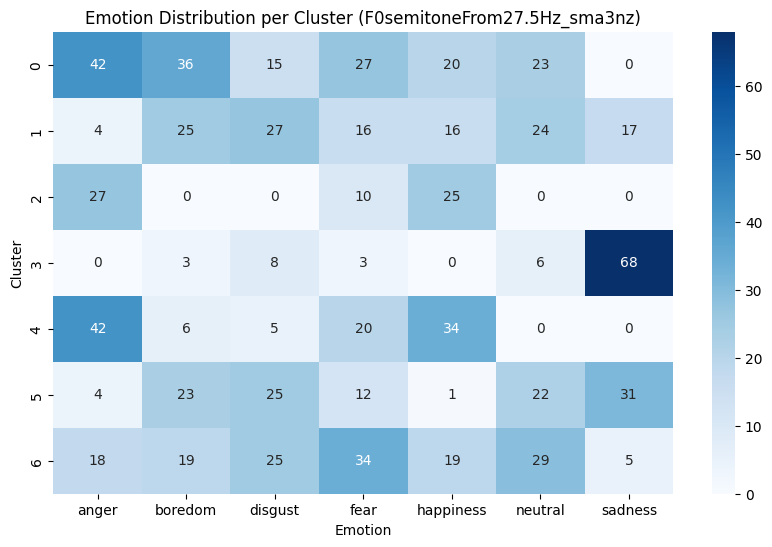

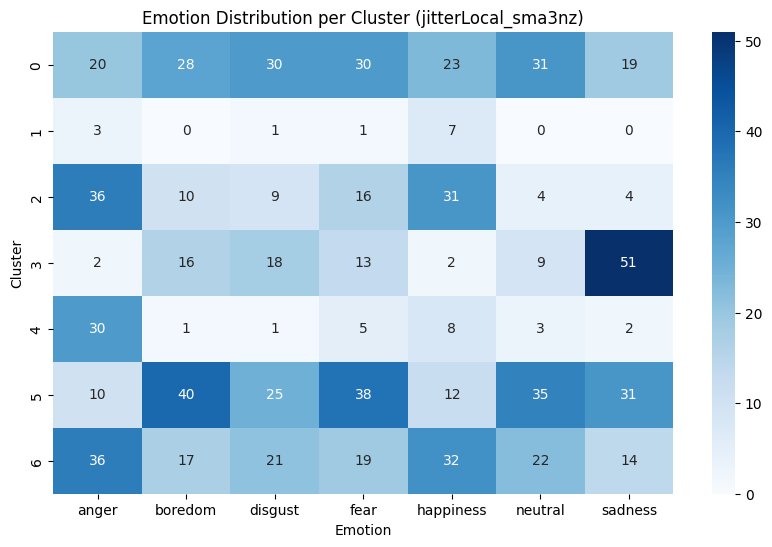

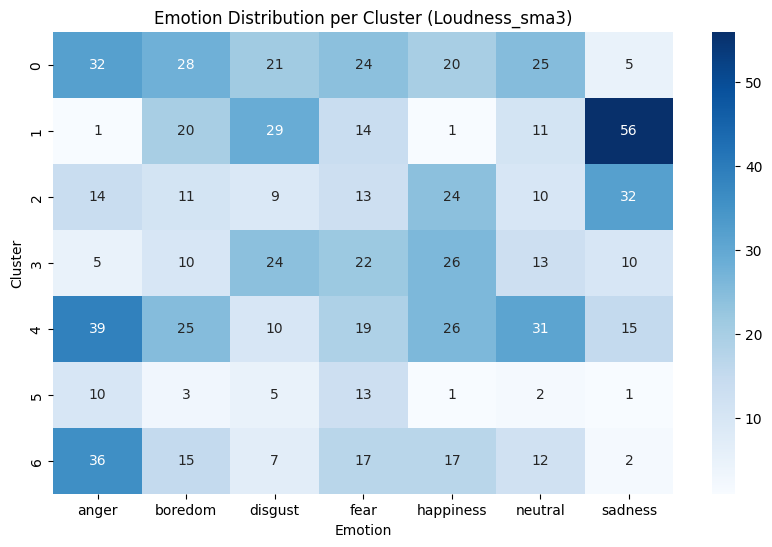

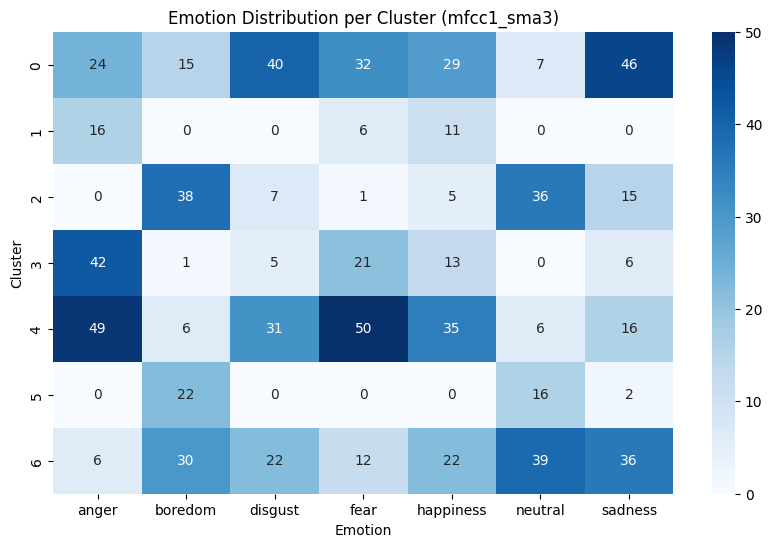

In [12]:
features_to_cluster = [
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "Loudness_sma3",
    "mfcc1_sma3"
]

for feature in features_to_cluster:
    
    X = final_df[[feature]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=7, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    temp_df = final_df.copy()
    temp_df["cluster"] = clusters
    
    heatmap_data = pd.crosstab(temp_df["cluster"], temp_df["emotion"])
    
    plt.figure(figsize=(10,6))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Emotion Distribution per Cluster ({feature})")
    plt.xlabel("Emotion")
    plt.ylabel("Cluster")
    plt.show()

Another way of analyzing how emotions relate to your clusters would be to calculate the cluster purity score. The cluster purity tells you the degree to which the clusters contain a single class (emotion)

In [13]:
features_to_cluster = [
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "Loudness_sma3",
    "mfcc1_sma3"
]

for feature in features_to_cluster:
    
    X = final_df[[feature]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=7, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    temp_df = final_df.copy()
    temp_df["cluster"] = clusters
    
    contingency_table = pd.crosstab(temp_df["cluster"], temp_df["emotion"])
    
    N = len(temp_df)
    max_per_cluster = contingency_table.max(axis=1)
    purity = max_per_cluster.sum() / N
    
    print(f"Purity for {feature}: {purity:.4f}")

Purity for F0semitoneFrom27.5Hz_sma3nz: 0.3321
Purity for jitterLocal_sma3nz: 0.2831
Purity for Loudness_sma3: 0.2868
Purity for mfcc1_sma3: 0.3100


### Clustering vowels

In [16]:
# Extract acoustic features for the DAIS dataset
# Define openSMILE extractor
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors
)

selected_features = [
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "Loudness_sma3",
    "mfcc1_sma3",
    "mfcc2_sma3",
    "mfcc3_sma3",
    "mfcc4_sma3"
]

all_features = []

base_path = "dais"

# Loop over subjects
for subject in tqdm(os.listdir(base_path), desc="Subjects"):
    
    subject_path = os.path.join(base_path, subject, "audio")
    
    if not os.path.exists(subject_path):
        continue
    
    # Loop over files
    for file in os.listdir(subject_path):
        
        if file.endswith(".wav"):
            
            full_path = os.path.join(subject_path, file)
            
            features = smile.process_file(full_path)
            features = features[selected_features]
            features = features.dropna()
            
            if len(features) == 0:
                continue
            
            file_features = features.mean()
            file_dict = file_features.to_dict()
            
            vowel = file.split("_")[1].split("-")[-1]
            
            file_dict["file"] = full_path
            file_dict["vowel"] = vowel
            
            all_features.append(file_dict)

df_dais = pd.DataFrame(all_features)

print(df_dais.head())
print("Shape:", df_dais.shape)

Subjects: 100%|██████████████████████████████████████████████████████████████████████████| 9/9 [02:31<00:00, 16.82s/it]

   F0semitoneFrom27.5Hz_sma3nz  jitterLocal_sma3nz  Loudness_sma3  mfcc1_sma3  \
0                     3.949863            0.001612       0.393940   15.940294   
1                     5.130753            0.011460       0.300341   17.281197   
2                     5.233213            0.003798       0.351827   18.149578   
3                     5.096852            0.001279       0.281272   17.516352   
4                     4.950197            0.002707       0.235056   17.390472   

   mfcc2_sma3  mfcc3_sma3  mfcc4_sma3  \
0    5.087754    7.287503   12.431080   
1    9.034579   12.277832   14.953195   
2    4.314999    9.257734   13.617846   
3   10.966755   12.972210   15.207555   
4   11.957587   14.701000   16.286757   

                                                file vowel  
0  dais\sub-01\audio\sub-01_task-overt-aa_run-01_...    aa  
1  dais\sub-01\audio\sub-01_task-overt-aa_run-02_...    aa  
2  dais\sub-01\audio\sub-01_task-overt-aa_run-03_...    aa  
3  dais\sub-01\audio\s

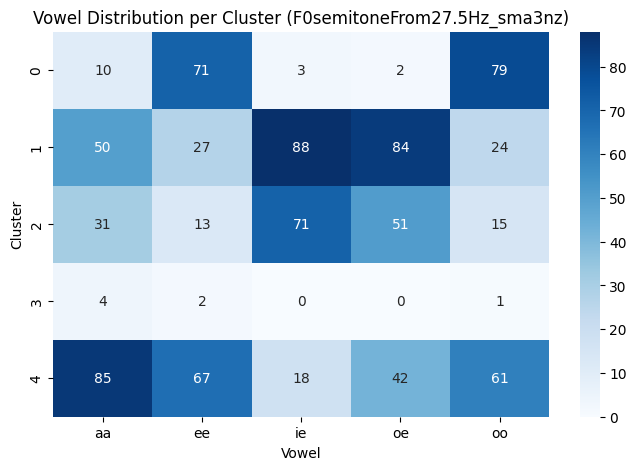

Purity for F0semitoneFrom27.5Hz_sma3nz: 0.3637
--------------------------------------------------


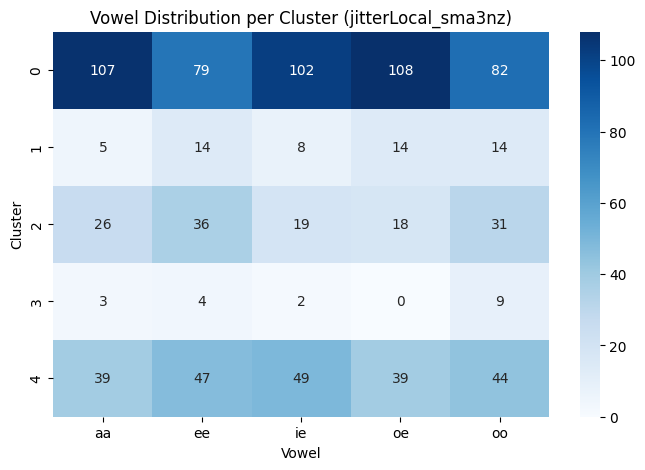

Purity for jitterLocal_sma3nz: 0.2403
--------------------------------------------------


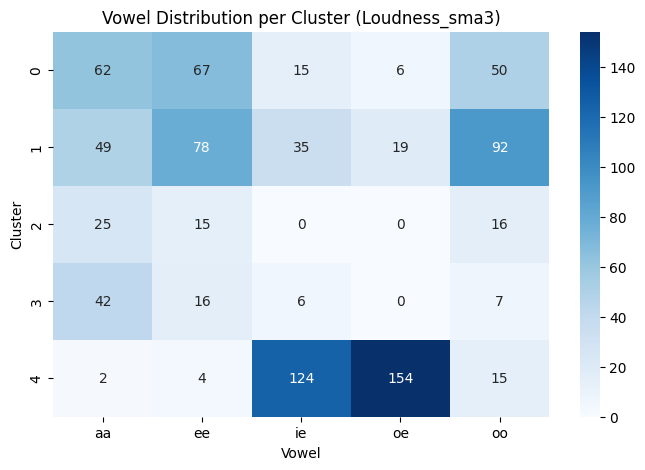

Purity for Loudness_sma3: 0.4227
--------------------------------------------------


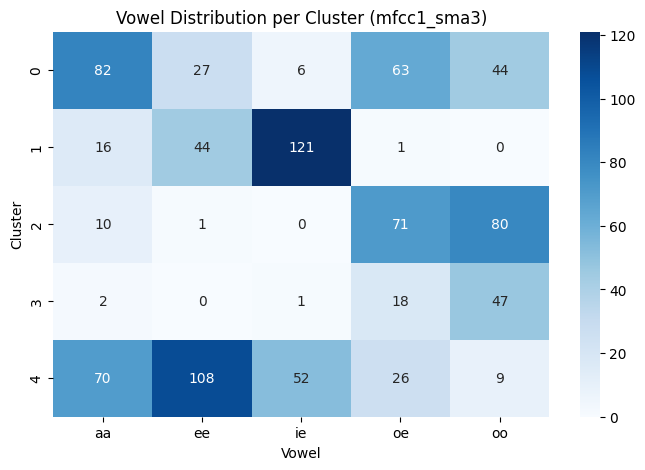

Purity for mfcc1_sma3: 0.4872
--------------------------------------------------


In [17]:
features_to_cluster = [
    "F0semitoneFrom27.5Hz_sma3nz",
    "jitterLocal_sma3nz",
    "Loudness_sma3",
    "mfcc1_sma3"
]

for feature in features_to_cluster:
    
    # Extract single feature
    X = df_dais[[feature]].values
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-means with 5 clusters (5 vowels)
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    temp_df = df_dais.copy()
    temp_df["cluster"] = clusters
    
    # Create heatmap data
    heatmap_data = pd.crosstab(temp_df["cluster"], temp_df["vowel"])
    
    # Plot heatmap
    plt.figure(figsize=(8,5))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Vowel Distribution per Cluster ({feature})")
    plt.xlabel("Vowel")
    plt.ylabel("Cluster")
    plt.show()
    
    # Calculate purity
    N = len(temp_df)
    max_per_cluster = heatmap_data.max(axis=1)
    purity = max_per_cluster.sum() / N
    
    print(f"Purity for {feature}: {purity:.4f}")
    print("-" * 50)

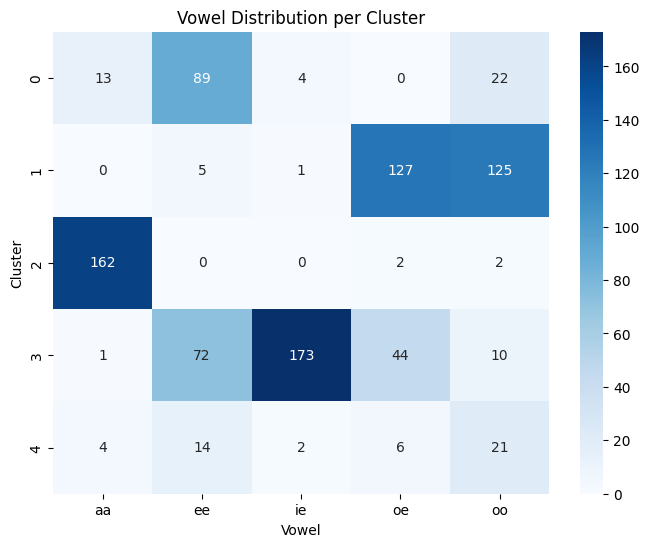

DAIS Vowel Clustering Purity: 0.6363


In [18]:
# Combine all features
# Cluster with 5 Clusters
X = df_dais[selected_features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_dais["cluster"] = clusters

# Heatmap
heatmap_data = pd.crosstab(df_dais["cluster"], df_dais["vowel"])

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues")
plt.title("Vowel Distribution per Cluster")
plt.xlabel("Vowel")
plt.ylabel("Cluster")
plt.show()

# Purity
contingency_table = pd.crosstab(df_dais["cluster"], df_dais["vowel"])

N = len(df_dais)
max_per_cluster = contingency_table.max(axis=1)

purity = max_per_cluster.sum() / N

print(f"DAIS Vowel Clustering Purity: {purity:.4f}")
